In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=12, walltime='04:00:00')
cluster = PBSCluster(cores=6, processes=6,  walltime='02:00:00')
w = cluster.scale(12*2)
#w = cluster.scale(12*1)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.135.36.187:43498 Dashboard: /user/yux/proxy/8787/status,Cluster Workers: 6 Cores: 6 Memory: 100.02 GB


___________
# Common info.

In [6]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/hourly_rms/'
dij=4
Nt, Ni, Nj = 24*40, 376, 188

In [7]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>


___________
# Term 1: time acceleration

### du/dt and dv/dt

## Estimated using 1-year SSU, SSV outputs

In [7]:
dsU = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSU'))
dsU = dsU.isel(time=slice(len(dsU.time)//Nt *Nt)).isel(i_g=slice(0,None,dij), j=slice(0,None,dij))
dsU = dsU.rename({'i_g': 'i'})
dsV = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSV'))
dsV = dsV.isel(time=slice(len(dsV.time)//Nt *Nt)).isel(i=slice(0,None,dij), j_g=slice(0,None,dij))
dsV = dsV.rename({'j_g': 'j'})
dsU

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<chunksize=(8640,), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    iters    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.68e+07 3.68e+07
Data variables:
    SSU      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 1080, 1080), meta=np.ndarray>

In [8]:
for face in range(13):
#for face in [2,3,4,5,6,7,8,9,10,11,12]:
    
    du_dt = ( dsU['SSU'].isel(face=face).shift(time=-1) - dsU['SSU'].isel(face=face) )/3600
    dv_dt = ( dsV['SSV'].isel(face=face).shift(time=-1) - dsV['SSV'].isel(face=face) )/3600      
    acceleration = np.sqrt( (du_dt**2).mean(['time']) + (dv_dt**2).mean(['time']) )
    acceleration = np.real(acceleration).rename('acceleration')    
    Efile = E_dir+'rms_acceleration_f%02d.zarr'%face
    %time acceleration.to_dataset().to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

CPU times: user 1min 17s, sys: 5.09 s, total: 1min 22s
Wall time: 1min 21s
--- face 0 done
CPU times: user 1min 45s, sys: 8.38 s, total: 1min 54s
Wall time: 2min 30s
--- face 1 done
CPU times: user 1min 30s, sys: 5.38 s, total: 1min 35s
Wall time: 1min 44s
--- face 2 done
CPU times: user 1min 5s, sys: 2.67 s, total: 1min 7s
Wall time: 1min 6s
--- face 3 done
CPU times: user 1min 49s, sys: 8.82 s, total: 1min 58s
Wall time: 2min 46s
--- face 4 done
CPU times: user 1min, sys: 2.92 s, total: 1min 3s
Wall time: 1min 3s
--- face 5 done
CPU times: user 1min 41s, sys: 6.49 s, total: 1min 48s
Wall time: 2min 17s
--- face 6 done
CPU times: user 1min 42s, sys: 6.32 s, total: 1min 49s
Wall time: 2min 24s
--- face 7 done
CPU times: user 1min 51s, sys: 7.32 s, total: 1min 59s
Wall time: 2min 53s
--- face 8 done
CPU times: user 1min 33s, sys: 5.81 s, total: 1min 39s
Wall time: 1min 42s
--- face 9 done
CPU times: user 1min 26s, sys: 8.04 s, total: 1min 34s
Wall time: 1min 40s
--- face 10 done
CPU tim

_______
# Term 2 Pressure gradient (grad Eta)

## estiamted using AP's geostrophic outputs

In [9]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/hourly_rms/'

grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd])

In [10]:
# spatial strides for decimation
dij=4
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = E_dir+'rms_pressure_gradient_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))
      
        rms_pressure_gradient = np.sqrt( (ds['u_gradp']**2).mean(['time'])+(ds['v_gradp']**2).mean(['time']) )
        rms_pressure_gradient = np.real(rms_pressure_gradient).rename('rms_pressure_gradient')  
        rms_pressure_gradient = rms_pressure_gradient.to_dataset()

        # store
        for c in rms_pressure_gradient.coords:
            try:
                del rms_pressure_gradient[c].encoding['chunks']
            except:
                print(c)        
        rms_pressure_gradient = rms_pressure_gradient.chunk({'i': 24*8, 'j':47*4})
        %time rms_pressure_gradient.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

mask
CPU times: user 22.9 s, sys: 1.55 s, total: 24.5 s
Wall time: 1min 9s
--- face 0 done
mask
CPU times: user 29.6 s, sys: 2.1 s, total: 31.7 s
Wall time: 2min 9s
--- face 1 done
mask
CPU times: user 26 s, sys: 1.73 s, total: 27.7 s
Wall time: 1min 22s
--- face 2 done
mask
CPU times: user 21.3 s, sys: 1.26 s, total: 22.6 s
Wall time: 50.5 s
--- face 3 done
mask
CPU times: user 29.2 s, sys: 1.94 s, total: 31.2 s
Wall time: 2min 24s
--- face 4 done
mask
CPU times: user 18.5 s, sys: 1.04 s, total: 19.5 s
Wall time: 35.1 s
--- face 5 done
mask
CPU times: user 28 s, sys: 1.77 s, total: 29.8 s
Wall time: 1min 11s
--- face 6 done
mask
CPU times: user 30.7 s, sys: 2.2 s, total: 32.9 s
Wall time: 2min 5s
--- face 7 done
mask
CPU times: user 29.7 s, sys: 2.23 s, total: 31.9 s
Wall time: 2min 36s
--- face 8 done
mask
CPU times: user 26 s, sys: 1.98 s, total: 28 s
Wall time: 1min 19s
--- face 9 done
mask
CPU times: user 25.7 s, sys: 1.69 s, total: 27.4 s
Wall time: 1min 19s
--- face 10 done
mask

_______
# Term 3. Linear Coriolis (fuv)

In [11]:
# spatial strides for decimation
dij=4
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = E_dir+'rms_fuv_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))

        
        rms_fuv = np.sqrt( ((ds['u_coriolis_linear'])**2).mean(['time'])+((ds['v_coriolis_linear'])**2).mean(['time']) )
        rms_fuv = np.real(rms_fuv).rename('rms_fuv')  
        rms_fuv = rms_fuv.to_dataset()

        # store
        for c in rms_fuv.coords:
            try:
                del rms_fuv[c].encoding['chunks']
            except:
                print(c)        
        rms_fuv = rms_fuv.chunk({'i': 24*8, 'j':47*4})
        %time rms_fuv.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

mask
CPU times: user 22.6 s, sys: 1.39 s, total: 24 s
Wall time: 1min 2s
--- face 0 done
mask
CPU times: user 29.4 s, sys: 2.26 s, total: 31.7 s
Wall time: 2min 8s
--- face 1 done
mask
CPU times: user 25.2 s, sys: 1.89 s, total: 27.1 s
Wall time: 1min 19s
--- face 2 done
mask
CPU times: user 20.4 s, sys: 1.32 s, total: 21.7 s
Wall time: 47.8 s
--- face 3 done
mask
CPU times: user 30.1 s, sys: 2.33 s, total: 32.4 s
Wall time: 2min 21s
--- face 4 done
mask
CPU times: user 17.8 s, sys: 1.17 s, total: 19 s
Wall time: 33.1 s
--- face 5 done
mask
CPU times: user 29.5 s, sys: 2.22 s, total: 31.7 s
Wall time: 1min 47s
--- face 6 done
mask
CPU times: user 28.5 s, sys: 1.89 s, total: 30.4 s
Wall time: 2min 2s
--- face 7 done
mask
CPU times: user 30.5 s, sys: 2.37 s, total: 32.9 s
Wall time: 2min 33s
--- face 8 done
mask
CPU times: user 25.4 s, sys: 1.8 s, total: 27.2 s
Wall time: 1min 15s
--- face 9 done
mask
CPU times: user 24.6 s, sys: 1.6 s, total: 26.2 s
Wall time: 1min 17s
--- face 10 done


_______
# Term 4. Ageostrophic momemtum (fuv_a)

In [12]:
# spatial strides for decimation
dij=4
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = E_dir+'rms_fuv_a_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))

        
        rms_fuv_a = np.sqrt( ((ds['u_gradp']-ds['u_coriolis_linear'])**2).mean(['time'])+((ds['v_gradp']-ds['v_coriolis_linear'])**2).mean(['time']) )
        rms_fuv_a = np.real(rms_fuv_a).rename('rms_fuv_a')  
        rms_fuv_a = rms_fuv_a.to_dataset()

        # store
        for c in rms_fuv_a.coords:
            try:
                del rms_fuv_a[c].encoding['chunks']
            except:
                print(c)        
        rms_fuv_a = rms_fuv_a.chunk({'i': 24*8, 'j':47*4})
        %time rms_fuv_a.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

mask
CPU times: user 40.5 s, sys: 2.69 s, total: 43.2 s
Wall time: 2min 6s
--- face 0 done
mask
CPU times: user 50.9 s, sys: 3.32 s, total: 54.2 s
Wall time: 4min 9s
--- face 1 done
mask
CPU times: user 46.9 s, sys: 3.21 s, total: 50.1 s
Wall time: 2min 36s
--- face 2 done
mask
CPU times: user 37.1 s, sys: 2.38 s, total: 39.5 s
Wall time: 1min 36s
--- face 3 done
mask
CPU times: user 57.4 s, sys: 3.81 s, total: 1min 1s
Wall time: 4min 41s
--- face 4 done
mask
CPU times: user 28.7 s, sys: 1.9 s, total: 30.6 s
Wall time: 1min 3s
--- face 5 done
mask
CPU times: user 56.9 s, sys: 3.9 s, total: 1min
Wall time: 2min 54s
--- face 6 done
mask
CPU times: user 57.5 s, sys: 3.79 s, total: 1min 1s
Wall time: 4min 7s
--- face 7 done
mask
CPU times: user 59.7 s, sys: 4.29 s, total: 1min 3s
Wall time: 5min 8s
--- face 8 done
mask
CPU times: user 47.4 s, sys: 3.62 s, total: 51 s
Wall time: 2min 29s
--- face 9 done
mask
CPU times: user 45.7 s, sys: 2.76 s, total: 48.4 s
Wall time: 2min 32s
--- face 10 

____________

# Term 5 Nonlinear term (12 months)

In [19]:
F = [0,1,2,3,4,5,6,7,8,9,10,11,12]

In [22]:
R_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/hourly_8640/'

In [23]:
for face in F:
    
    nonlinear_x = xr.concat([xr.open_zarr(R_dir+'nolinear_x_f%02d_t%04d.zarr'%(face,t)) for t in T], dim='time')
    nonlinear_y = xr.concat([xr.open_zarr(R_dir+'nolinear_y_f%02d_t%04d.zarr'%(face,t)) for t in T], dim='time')
    nonlinear = np.sqrt( (nonlinear_x.nolinear_x**2).mean(['time']) + (nonlinear_y.nolinear_y**2).mean(['time']) )
    nonlinear = np.real(nonlinear).rename('nonlinear')
    Efile = E_dir+'rms_nonlinear_f%02d.zarr'%face
    nonlinear.to_dataset().to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


--- face 0 done


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


--- face 1 done


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


--- face 2 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


--- face 3 done


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


--- face 4 done


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


--- face 5 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


--- face 6 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


--- face 7 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


--- face 8 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


--- face 9 done
--- face 10 done
--- face 11 done
--- face 12 done


______________
# E_omega

In [5]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for face in face_all:
    
    ds = xr.open_zarr(work_data_dir+'xy/total_uv/E_uv_f%02d.zarr'%(face))
    chunks={'i': 188, 'j':192, 'freq_time':1440}
    ds = ds.chunk(chunks)     
    E = ds.uv
    df=E.freq_time[1]-E.freq_time[0]
    
    # near-inertial
    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
    f_cpd_llc = f_llc*86400/2./np.pi  
    #E_f = (E.where((abs(E.freq_time+f_cpd_llc)<0.1), other=0.)*df).sum(dim='freq_time')
    
    E_omega = np.sqrt((E.where((abs(E.freq_time)>abs(f_cpd_llc)-0.1), other=0.)*df*((E.freq_time*6/86400)**2)).sum(dim='freq_time'))    
    E_omega = E_omega.chunk({'i': 1080, 'j': 1080}) 
    E_omega = np.real(E_omega).rename('E_omega')

    E_omega_all = np.sqrt((E*df*((E.freq_time*6/86400)**2)).sum(dim='freq_time'))
    E_omega_all = E_omega_all.chunk({'i': 1080, 'j': 1080}) 
    E_omega_all = np.real(E_omega_all).rename('E_omega_all')

    E_band = xr.merge([E_omega_all, E_omega])    
    file_E = work_data_dir+'xy/momentum_balance/E_omega/E_omega_f%02d.zarr'%face
    E_band.to_zarr(file_E, mode='w')  
    print('face %d done'%face )    

face 0 done
face 1 done
face 2 done
face 3 done
face 4 done
face 5 done
face 6 done
face 7 done
face 8 done
face 9 done
face 10 done
face 11 done
face 12 done


_______________
# Figures

In [8]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

In [9]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='110m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 2e-5, 4e-5, 6e-5, 8e-5])
        cb.ax.set_yticklabels(['0','2','4','6','8'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
        ax.set_ylim(-60., 60.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [10]:
F = [0,1,2,3,4,5,6,7,8,9,10,11,12]

In [11]:
# Linear Coriolis term
ds = xr.concat([xr.open_zarr(E_dir+'rms_fuv_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
plot_pretty(ds.rms_fuv.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (ds.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_08a_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [12]:
# Pressure gradient
ds = xr.concat([xr.open_zarr(E_dir+'rms_pressure_gradient_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
plot_pretty(ds.rms_pressure_gradient.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (ds.Depth>500)  & (ds.j!=40)), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_08b_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [13]:
# Ageostrophic Coriolis term
ds = xr.concat([xr.open_zarr(E_dir+'rms_fuv_a_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
plot_pretty(ds.rms_fuv_a.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (ds.Depth>500) & (ds.j!=40) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_09a_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [14]:
# Acceleration
ds = xr.concat([xr.open_zarr(E_dir+'rms_acceleration_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
grd_rspec_dij = grd_rspec.isel(i=slice(0,None,dij), j=slice(0,None,dij))
ds = ds.assign_coords(**grd_rspec_dij.variables)
plot_pretty(ds.acceleration.where( (ice>0) & (ds.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_09b_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [15]:
# Nonlinear advection term
ds = xr.concat([xr.open_zarr(E_dir+'rms_nolinear_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
plot_pretty(ds.nolinear.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (ds.Depth>500)  & (ds.j!=40)), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_09c_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [16]:
# Residual term
ds = xr.concat([xr.open_zarr(E_dir+'rms_residuals_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
plot_pretty(ds.residuals.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (ds.Depth>500)  & (ds.j!=40)), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_09d_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

## acceleration term (1h or 2h)

In [17]:
# Acceleration
ds = xr.concat([xr.open_zarr(E_dir+'rms_acceleration_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
grd_rspec_dij = grd_rspec.isel(i=slice(0,None,dij), j=slice(0,None,dij))
ds = ds.assign_coords(**grd_rspec_dij.variables)
plot_pretty(ds.acceleration.where( (ice>0) & (ds.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_S3_acc1hour.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [18]:
# Acceleration
ds_2hours = xr.concat([xr.open_zarr(E_dir+'rms_acceleration_2hours_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
grd_rspec_dij = grd_rspec.isel(i=slice(0,None,dij), j=slice(0,None,dij))
ds_2hours = ds_2hours.assign_coords(**grd_rspec_dij.variables)
plot_pretty(ds_2hours.uv_t.where( (ice>0) & (ds_2hours.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_S3_acc2hour.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [19]:
plot_pretty( (ds.acceleration-ds_2hours.uv_t).where( (ice>0) & (ds_2hours.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_S3_acc_diff.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [19]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(work_data_dir+'xy/momentum_balance/E_omega/E_omega_f%02d.zarr'%(face)) for face in face_all] 
ds_omega = xr.concat(D, dim='face')
print(ds_omega)

<xarray.Dataset>
Dimensions:      (face: 13, i: 1080, j: 1080)
Coordinates:
    Depth        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxC          (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxG          (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyC          (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyG          (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_i          (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_j          (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i            (i) int64 0

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

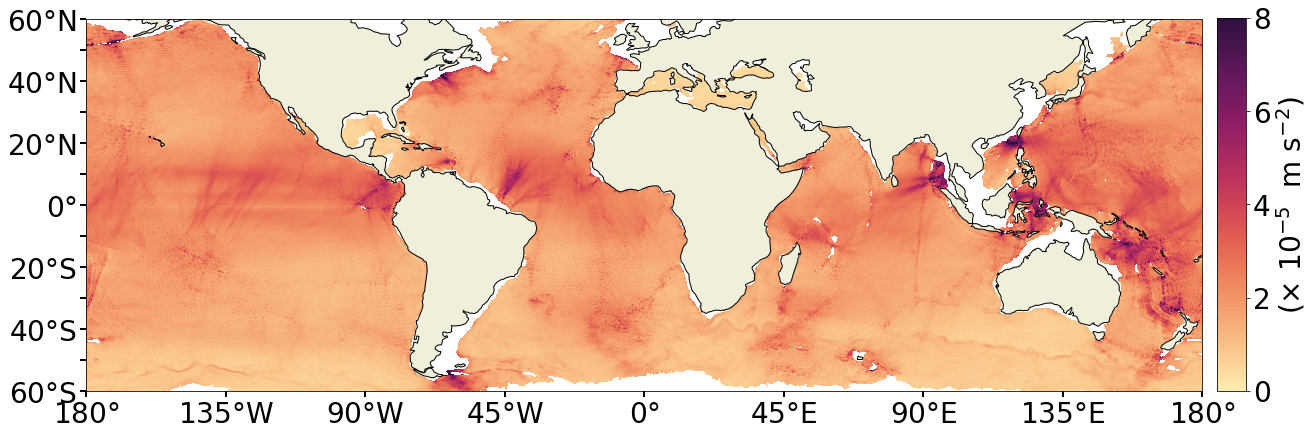

In [22]:
plot_pretty((ds_omega.E_omega).isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (ds_omega.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=8e-5, cmmap='matter', ignore_face=[6])

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

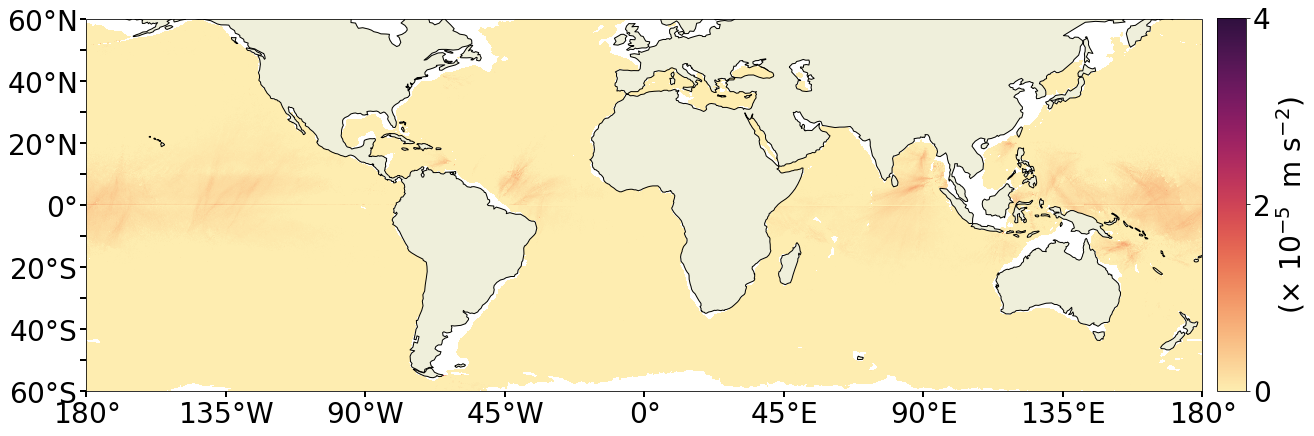

In [27]:
plot_pretty((ds_omega.E_omega_all-ds.acceleration).isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (ds_omega.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

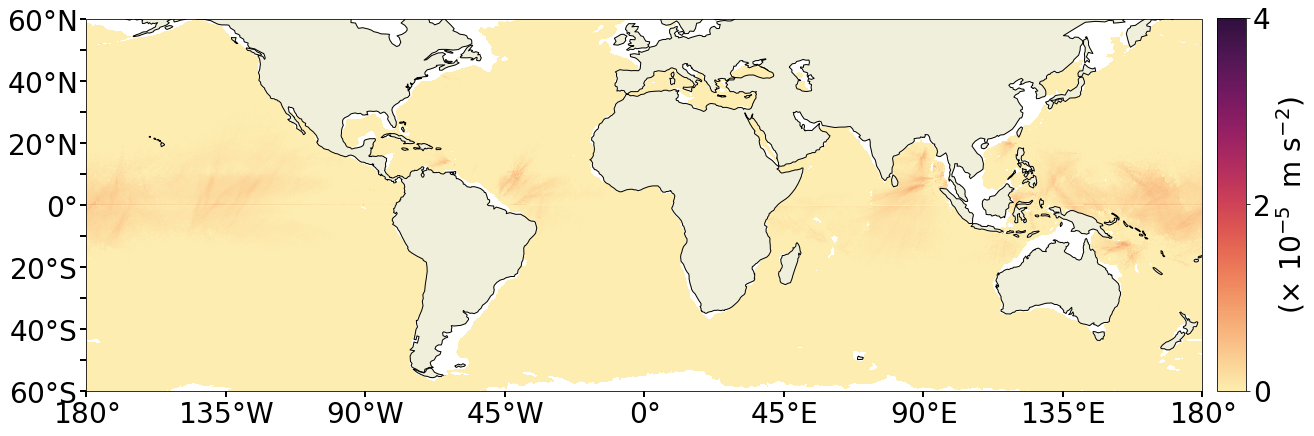

In [28]:
plot_pretty((ds_omega.E_omega-ds.acceleration).isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (ds_omega.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

In [ ]:
Tau_ELD = xr.open_dataset('/work/ALT/swot/aval/syn/xy/momentum_balance/data/Tau_ELD_rms.nc')
Tau_ELD_rms = Tau_ELD.Tau_ELD_rms

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

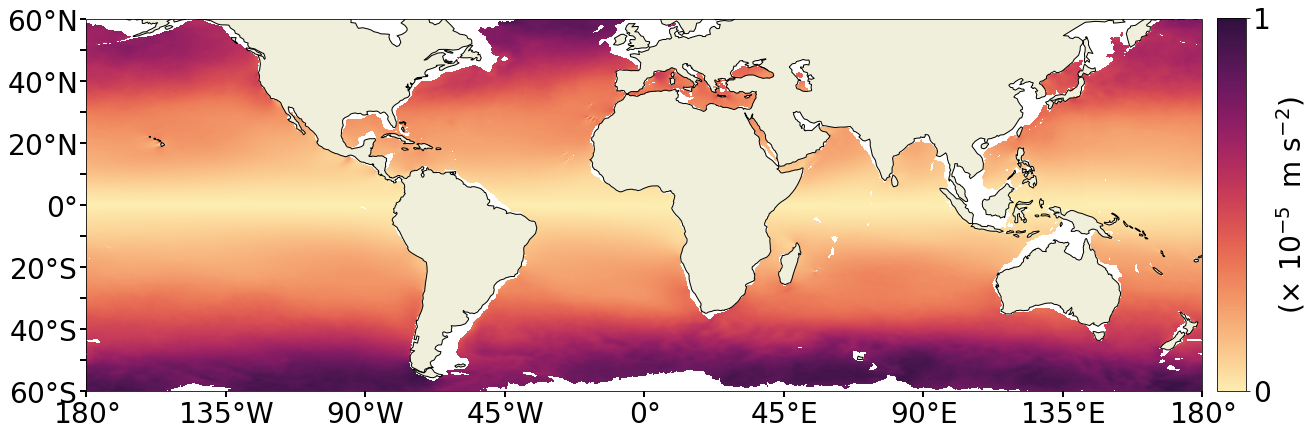

In [16]:
# Tau_ELD_rms
plot_pretty(Tau_ELD_rms.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (Tau_ELD_rms.Depth>500) ), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=1e-5, cmmap='matter', ignore_face=[6])

In [20]:
cluster.close()